In [57]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go

In [33]:
# Definir número de registros
n = 1000
rng = np.random.default_rng(42)

# Gerar atributos simplificados (mais relevantes para regressão linear múltipla)
# Vamos focar em: areaPrivativaM2, quartos, suites, vagasGaragem, distanciaPraiaM, idadeImovelAnos, andar (para aptos), bairro_enc (dummy numérica), precoVenda

# Atributos básicos
areaPrivativaM2 = rng.normal(80, 25, n).clip(30, 300)  # média 80 m², variando
quartos = rng.integers(1, 5, n)  # de 1 a 4 quartos
suites = np.clip(quartos - rng.integers(0, 2, n), 0, None)  # no máx = quartos
vagasGaragem = rng.integers(0, 3, n)  # de 0 a 2 vagas
distanciaPraiaM = rng.normal(2000, 1200, n).clip(50, 8000)  # 50m a 8km
idadeImovelAnos = rng.integers(0, 40, n)  # 0 (novo) até 40 anos
andar = rng.integers(0, 20, n)  # 0 = casa, até 20º andar
bairro_enc = rng.integers(1, 6, n)  # codificação de bairros principais (1–5)

# Definir preço base (m² médio JP ≈ 7445 em 2025)
base_price_m2 = 7000

# Modelo linear sintético (coeficientes realistas)
precoVenda = (
    areaPrivativaM2 * base_price_m2
    + quartos * 25000
    + suites * 35000
    + vagasGaragem * 20000
    - distanciaPraiaM * 50
    - idadeImovelAnos * 1500
    + andar * 3000
    + bairro_enc * 50000
)

# Adicionar ruído (5% do preço)
noise = rng.normal(0, precoVenda * 0.05)
precoVenda = (precoVenda + noise).clip(100000, None)  # nunca < 100k

# Criar DataFrame
df = pd.DataFrame({
    "areaPrivativaM2": areaPrivativaM2.round(1),
    "quartos": quartos,
    "suites": suites,
    "vagasGaragem": vagasGaragem,
    "distanciaPraiaM": distanciaPraiaM.clip(0),
    "idadeImovelAnos": idadeImovelAnos,
    "andar": andar,
    "bairroEnc": bairro_enc,
    "precoVenda": precoVenda.round(2)
})

In [34]:
df

,areaPrivativaM2,quartos,suites,vagasGaragem,distanciaPraiaM,idadeImovelAnos,andar,bairroEnc,precoVenda
0,87.6,1,1,0,942.513863,35,8,5,836492.41
1,54.0,3,3,2,2260.928498,7,11,5,728790.05
2,98.8,2,2,2,1957.010304,11,4,1,792537.50
3,103.5,2,1,2,1879.642799,38,2,1,825904.55
4,31.2,3,2,0,1862.813398,12,2,3,436713.04
...,...,...,...,...,...,...,...,...,...
995,88.8,3,3,2,50.000000,38,19,1,923199.27
996,99.2,4,3,1,1732.613389,29,19,4,1058896.17
997,83.0,3,3,0,3365.548123,28,4,1,631655.58
998,83.3,1,0,0,2022.073059,30,0,5,646308.59


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   areaPrivativaM2  1000 non-null   float64
 1   quartos          1000 non-null   int64  
 2   suites           1000 non-null   int64  
 3   vagasGaragem     1000 non-null   int64  
 4   distanciaPraiaM  1000 non-null   float64
 5   idadeImovelAnos  1000 non-null   int64  
 6   andar            1000 non-null   int64  
 7   bairroEnc        1000 non-null   int64  
 8   precoVenda       1000 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 70.4 KB


<Axes: >

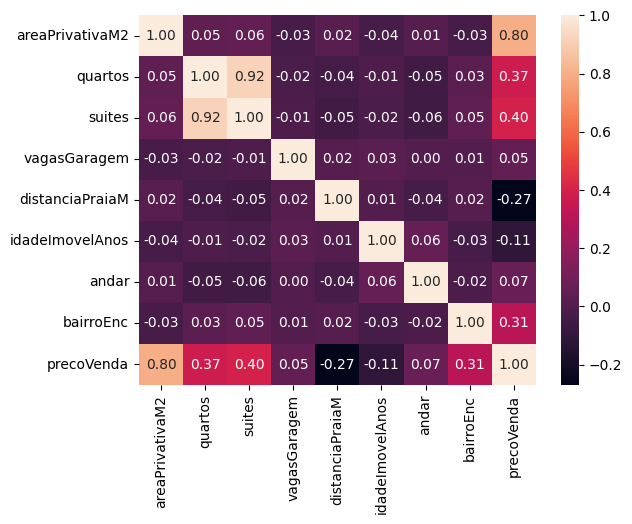

In [60]:
plt.Figure(figsize=(10, 8))
sn.heatmap(df.corr(), annot=True, fmt=".2f")


In [67]:
x = df.drop(columns=['quartos', 'vagasGaragem',
        'distanciaPraiaM', 'idadeImovelAnos', 'andar', 'bairroEnc',
        'precoVenda']).values
y = df.iloc[:, 8].values

x, y

(array([[ 87.6,   1. ],
        [ 54. ,   3. ],
        [ 98.8,   2. ],
        ...,
        [ 83. ,   3. ],
        [ 83.3,   0. ],
        [100.6,   1. ]], shape=(1000, 2)),
 array([ 836492.41,  728790.05,  792537.5 ,  825904.55,  436713.04,
         516690.6 ,  832939.78,  615939.24,  759828.25,  404776.8 ,
        1146544.05,  663186.1 , 1020536.13, 1051208.22,  676373.17,
         529947.74,  842420.74,  786350.44,  940067.02,  592063.56,
         908633.75,  472009.46,  973690.1 ,  676121.25,  644898.07,
         551208.47,  893025.87,  963727.68, 1071032.4 ,  668631.67,
        1240330.17,  613984.87,  564185.61,  430391.84, 1023011.03,
        1000233.53,  781056.02,  528632.68,  767586.97,  984312.28,
         676336.4 , 1049999.29,  821831.46,  824993.94,  782950.47,
         799337.86,  825357.45,  767159.46,  862356.04,  802779.92,
         717741.3 ,  924875.84,  493116.1 ,  845265.51,  772948.77,
         585097.68,  885362.08,  960377.44,  577558.8 ,  892073.01,
        

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((700, 2), (300, 2), (700,), (300,))

In [70]:
model = LinearRegression()
model.fit(x_train, y_train)

y_predict = model.predict(x_test)

In [71]:
mean_squared_error(y_predict, y_test)
r2_score(y_predict, y_test)

0.6733493776783188

In [74]:
# Criar uma malha para superfície de predição
metragem_range = np.linspace(x_train.T[0].min(), x_train.T[0].max(), 50)
quartos_range = np.linspace(x_train.T[1].min(), x_train.T[1].max(), 50)
M, Q = np.meshgrid(metragem_range, quartos_range)
Z = model.predict(np.c_[M.ravel(), Q.ravel()]).reshape(M.shape)

# Gráfico 3D interativo
fig = go.Figure()

# Pontos reais
fig.add_trace(go.Scatter3d(
    x=x_train.T[0], y=x_train.T[1], z=y,
    mode="markers",
    marker=dict(size=3, color="blue", opacity=0.5),
    name="Dados reais"
))

# Superfície de regressão
fig.add_trace(go.Surface(
    x=metragem_range, y=quartos_range, z=Z,
    colorscale="Viridis", opacity=0.7,
    name="Plano de regressão"
))

# Layout
fig.update_layout(
    scene=dict(
        xaxis_title="areaPrivativaM2",
        yaxis_title="suites",
        zaxis_title="Preço (R$)"
    ),
    title="Regressão Linear Múltipla (Preço vs Metragem & Quartos)",
    template='plotly_dark' 
)

fig.show()
